In [3]:
import numpy as np
import pandas as pd
from copy import deepcopy
import random
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import loglaplace, lognorm, laplace, norm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.special import erf
warnings.filterwarnings('ignore')
sns.set(style="white", context="talk")
from matplotlib import rc

rc('text', usetex=True)
np.random.seed(42)

## S3.2 Simulating the lower-bound

In [4]:
n = 50
θ = 2
μ_ = np.linspace(-3,3,10)
σ_ = np.logspace(-1,1,21)
ω = (n-2)/(3*n - 2)

In [5]:
def β_min(θ,ω,μ):
    return np.max([θ/(1-ω),μ])

#### Pareto

In [6]:
def pareto(x,μ,σ):
    return (μ/x)**σ

In [7]:
def F(β,μ,σ,n):
    α = 1/σ
    F_term = (1-pareto(β,μ,α))
    other_term = 1 - (1-pareto(n*β,μ,α))**n
    return F_term*other_term

In [8]:
def find_max(μ,σ,n,multiple = 10.0):
    βmin = β_min(θ,ω,μ)
    x = np.linspace(βmin, multiple*βmin,1000)
    F_ = F(x,μ,σ,n)
    max_ = np.max(F_)
    if(np.allclose(F_ - max_ , np.zeros(1000))):
        return max_
    if max_ == F_[-1]:
        new_multiple = multiple*10.0
        max_ = find_max(μ,σ,n,multiple = new_multiple)
    return max_

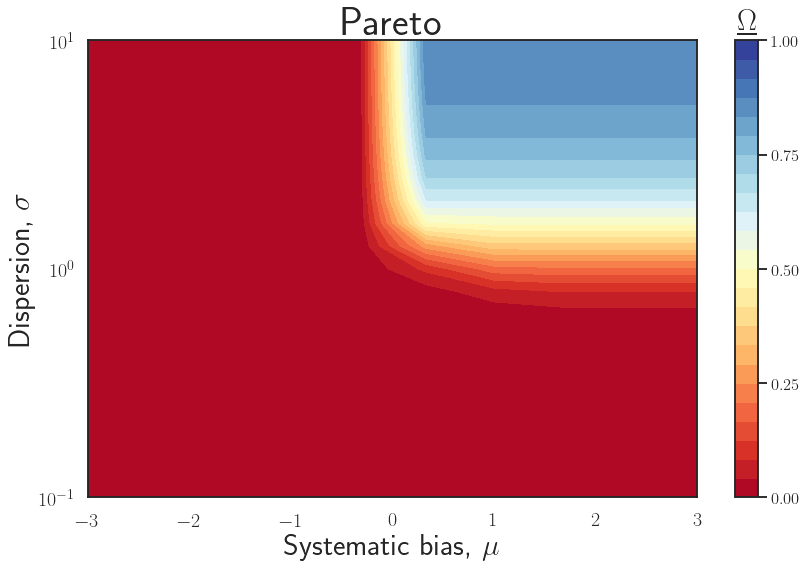

In [9]:

Ω_pareto = np.zeros([len(μ_),len(σ_)])
for i,μ in enumerate(μ_):
    for j,σ in enumerate(σ_):
        Ω_pareto[i,j] = find_max(μ,σ,n)
        
Ω_pareto[np.isnan(Ω_pareto)] = 0.0
        
sigma = 0
data = gaussian_filter(Ω_pareto, sigma)
μμ,σσ = np.meshgrid(μ_,σ_) 
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_yscale('log',basey=10)


main_cs = ax.contourf(μμ,σσ,data.T,levels=np.linspace(0,1,25),cmap='RdYlBu')
clb = fig.colorbar(main_cs, ticks=np.linspace(0,1,5))
clb.ax.set_title(r'\underline{$\Omega$}',fontsize=30)

ax.set_xlabel("Systematic bias, $\mu$",fontsize=30)
ax.set_ylabel('Dispersion, $\sigma$',fontsize=30)

ax.set_ylim(0.1,10)

ax.set_title("Pareto",fontsize=40)

ax.tick_params(labelsize=20)

plt.tight_layout()
plt.savefig('mainprop_pareto.pdf')

#### Lognormal

In [10]:
def F_lognorm(β,μ,σ,n):
    F_term = 0.5 + 0.5*erf((np.log(β) - μ)/σ/np.sqrt(2))
    other_term = 1 - (0.5 + 0.5*erf((np.log(n*β) - μ)/σ/np.sqrt(2)))**n
    return F_term*other_term

In [11]:
def find_max_lognorm(μ,σ,n,multiple = 10.0):
    βmin = β_min(θ,ω,μ)
    x = np.linspace(βmin, multiple*βmin,1000)
    F_ = F_lognorm(x,μ,σ,n)
    max_ = np.max(F_)
    if(np.allclose(F_ - max_ , np.zeros(1000))):
        return max_
    if max_ == F_[-1]:
        new_multiple = multiple*10.0
        max_ = find_max_lognorm(μ,σ,n,multiple = new_multiple)
    return max_

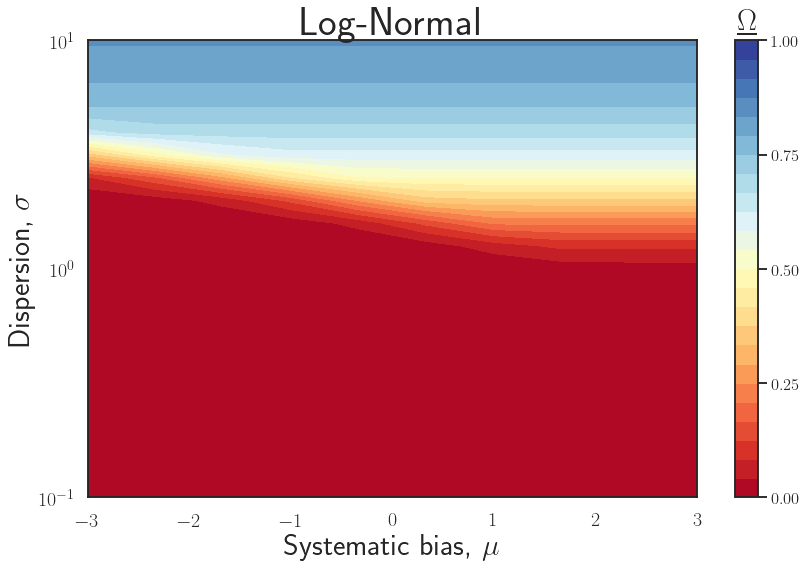

In [12]:
n = 50
θ = 2
μ_ = np.linspace(-3,3,10)
σ_ = np.logspace(-1,1,21)
ω = (n-2)/(3*n - 2)

Ω_lognorm = np.zeros([len(μ_),len(σ_)])
for i,μ in enumerate(μ_):
    for j,σ in enumerate(σ_):
        Ω_lognorm[i,j] = find_max_lognorm(μ+np.log(θ),σ,n)
        
sigma = 0
data = gaussian_filter(Ω_lognorm, sigma)
μμ,σσ = np.meshgrid(μ_,σ_) 
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_yscale('log',basey=10)


main_cs = ax.contourf(μμ,σσ,data.T,levels=np.linspace(0,1,25),cmap='RdYlBu')
clb = fig.colorbar(main_cs, ticks=np.linspace(0,1,5))
clb.ax.set_title(r'\underline{$\Omega$}',fontsize=30)

ax.set_xlabel("Systematic bias, $\mu$",fontsize=30)
ax.set_ylabel('Dispersion, $\sigma$',fontsize=30)

ax.set_ylim(0.1,10)

ax.set_title("Log-Normal",fontsize=40)

ax.tick_params(labelsize=20)

plt.tight_layout()
plt.savefig('mainprop_lognormal.pdf')

#### Loglaplace

In [13]:
def LogLaplaceCDF(x,θ,μ,σ):
    if np.log(x/θ) < μ:
        return 0.5*np.exp((np.log(x/θ) - μ)/σ)
    else:
        return 1 - 0.5*np.exp((μ - np.log(x/θ))/σ)

def F_loglaplace(β,θ,μ,σ,n):
    F_term = LogLaplaceCDF(β,θ,μ,σ)
    other_term = 1 - (LogLaplaceCDF(β*n,θ,μ,σ))**n
    return F_term*other_term

In [14]:
def find_max_loglaplace(θ,μ,σ,n,multiple = 10.0):
    βmin = β_min(θ,ω,μ)
    x = np.linspace(βmin, multiple*βmin,1000)
    F_ = np.asarray([F_loglaplace(y,θ,μ,σ,n) for y in x])
    max_ = np.max(F_)
    if(np.allclose(F_ - max_ , np.zeros(1000))):
        return max_
    if max_ == F_[-1]:
        new_multiple = multiple*10.0
        max_ = find_max_loglaplace(θ,μ,σ,n,multiple = new_multiple)
    return max_

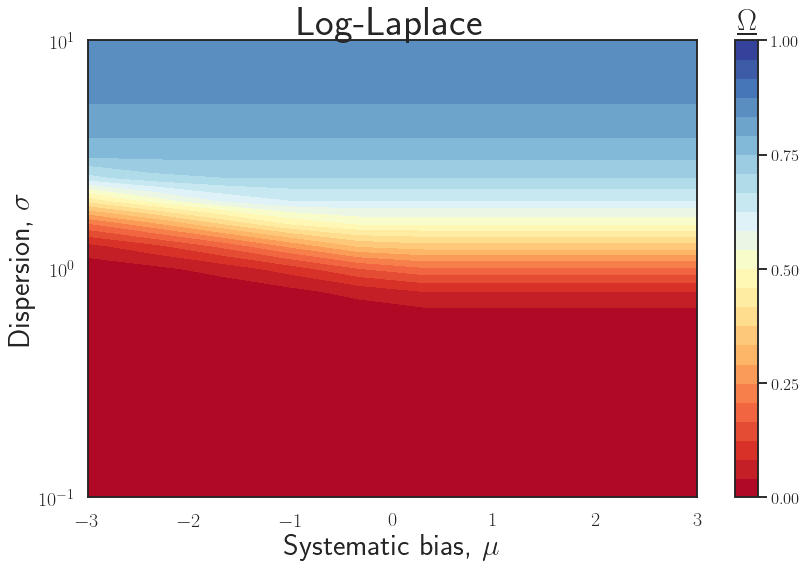

In [15]:
Ω_loglaplace = np.zeros([len(μ_),len(σ_)])
for i,μ in enumerate(μ_):
    for j,σ in enumerate(σ_):
        Ω_loglaplace[i,j] = find_max_loglaplace(θ,μ,σ,n)
        
sigma = 0
data = gaussian_filter(Ω_loglaplace, sigma)
μμ,σσ = np.meshgrid(μ_,σ_) 
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_yscale('log',basey=10)


main_cs = ax.contourf(μμ,σσ,data.T,levels=np.linspace(0,1,25),cmap='RdYlBu')
clb = fig.colorbar(main_cs, ticks=np.linspace(0,1,5))
clb.ax.set_title(r'\underline{$\Omega$}',fontsize=30)

ax.set_xlabel("Systematic bias, $\mu$",fontsize=30)
ax.set_ylabel('Dispersion, $\sigma$',fontsize=30)

ax.set_ylim(0.1,10)

ax.set_title("Log-Laplace",fontsize=40)

ax.tick_params(labelsize=20)

plt.tight_layout()
plt.savefig('mainprop_loglaplace.pdf')

#### Gaussian

In [16]:
def GaussianCDF(x,θ,μ,σ):
    return 0.5*(erf((x - (θ + μ))/σ/np.sqrt(2)) + erf((x + (θ + μ))/σ/np.sqrt(2)))
    #return norm.cdf(x, loc = θ + μ, scale = σ)

def F_Gaussian(β,θ,μ,σ,n):
    F_term = GaussianCDF(β,θ,μ,σ)
    other_term = 1 - (GaussianCDF(β*n,θ,μ,σ))**n
    return F_term*other_term

In [17]:
def find_max_Gaussian(θ,μ,σ,n,multiple = 10.0):
    βmin = β_min(θ,ω,μ)
    x = np.linspace(βmin, multiple*βmin,1000)
    F_ = np.asarray([F_Gaussian(y,θ,μ,σ,n) for y in x])
    max_ = np.max(F_)
    if(np.allclose(F_ - max_ , np.zeros(1000))):
        return max_
    if max_ == F_[-1]:
        new_multiple = multiple*10.0
        max_ = find_max_Gaussian(θ,μ,σ,n,multiple = new_multiple)
    return max_

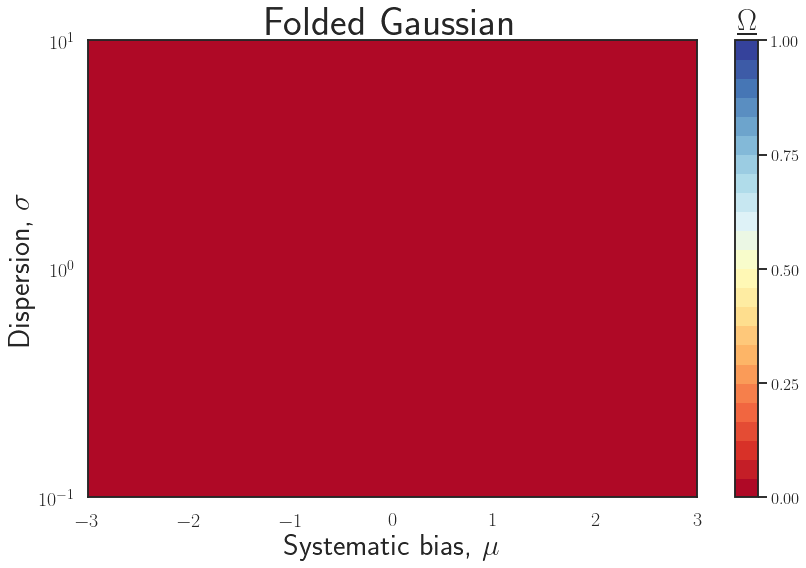

In [18]:
Ω_gaussian = np.zeros([len(μ_),len(σ_)])
for i,μ in enumerate(μ_):
    for j,σ in enumerate(σ_):
        Ω_gaussian[i,j] = find_max_Gaussian(θ,μ,σ,n)
        
sigma = 0
data = gaussian_filter(Ω_gaussian, sigma)
μμ,σσ = np.meshgrid(μ_,σ_) 
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_yscale('log',basey=10)


main_cs = ax.contourf(μμ,σσ,data.T,levels=np.linspace(0,1,25),cmap='RdYlBu')
clb = fig.colorbar(main_cs, ticks=np.linspace(0,1,5))
clb.ax.set_title(r'\underline{$\Omega$}',fontsize=30)

ax.set_xlabel("Systematic bias, $\mu$",fontsize=30)
ax.set_ylabel('Dispersion, $\sigma$',fontsize=30)

ax.set_title("Folded Gaussian",fontsize=40)

ax.set_ylim(0.1,10)

ax.tick_params(labelsize=20)

plt.tight_layout()
plt.savefig('mainprop_gaussian.pdf')